### Sumário

- Construção do sinal de teste
- Remoção de rúido com FFT
- Derivando uma função com FTT
- Precição no calculo da derivada com FFT vs aproximação por diferenças finitas

### Construção do sinal de teste

Para inicar vamos construir um sinal simples que usaremos ao para demonstrar a remoção de rúido e o cálculo da derivada com FFT.

Neste caso usaremos dois tons com frequências 100 e 250 Hz corrompidos por um ruído gaussiano.

$y = \sin(2\pi100x) + \sin(2\pi250x)$

$y_{nosie} = \sin(2\pi100x) + \sin(2\pi250x) + N(0, 1)$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fs = 2000 # Hz - Taxa de amostragem
tmax = 4 # s - Tempo do sinal amostrado


t = np.arange(0, tmax, 1.0/fs)
y = np.sin(2*np.pi*100*t)
y += 0.5*np.sin(2*np.pi*250*t)

y_noise = y + np.random.randn(t.shape[-1])

Sinal y e sinal com rúido

(0, 0.1)

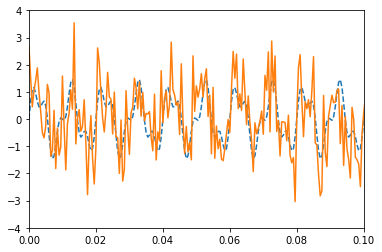

In [3]:
plt.plot(t, y, '--')
plt.plot(t, y_noise)
plt.ylim([-4, 4])
plt.xlim([0, 0.1])


Agora vamos calcular a FFT do sinal ruídoso.

In [4]:
freq = np.fft.fftfreq(t.shape[-1], 1/fs) # Frequencias discretas obtidas pela FFT
ft = np.fft.fft(y_noise)

(0, 300)

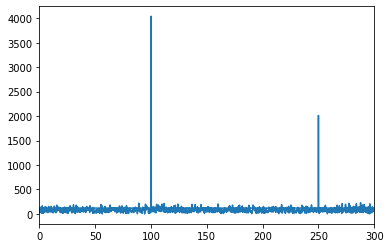

In [5]:
plt.plot(freq, np.abs(ft))
plt.xlim([0, 300])

Podemos ver que no grafico de densidade espectral que há dois picos correspondentes as frequências dos tons senoidais e um rupido distribuido por toda faixa de frequência.

### Remoçao de ruído com FFT

Para remover o ruído vamos zerar os coeficientes de baixo valor, deixando somente os coeficientes correspondentes aos tons senoidais e em seguida fazer a transformada inversa IFFT.

In [6]:
ft[np.abs(ft) < 300] = 0

(0, 300)

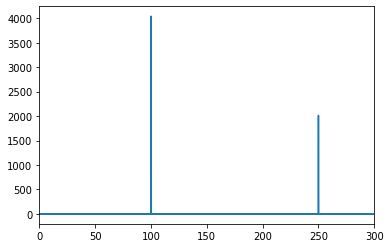

In [7]:
plt.plot(freq, np.abs(ft))
plt.xlim([0, 300])

Calculando a transformada inversa e plotando o sinal sem ruído.

In [8]:
y_ifft = np.real(np.fft.ifft(ft))

(0, 0.1)

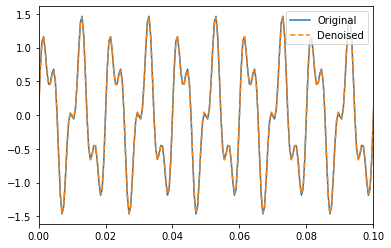

In [9]:
plt.plot(t, y_ifft)
plt.plot(t, y, '--')
plt.legend(["Original", "Denoised"])
plt.xlim([0, 0.1])

Podemos ver que o sinal sem ruído coincide com o sinal original e que praticamente todo o ruído foi removido.

###  Derivando uma função com FTT

Para calcular a derivada com FFT precisamos relembrar da relação entre a transformada de fourier de um função e sua derivada.

$F(f'(t)) = j\omega F(f(t))$

Ou seja, precisamos mutiplicar os coeficientes da transformada pelas frequências correspondentes e fazer a transformada inversa para recuperar a derivada.

In [10]:
w = 2*np.pi*freq*1j # Frequências w para cada coeficientes

In [11]:
ft_div = ft*w # FFT da derivada

(0, 300)

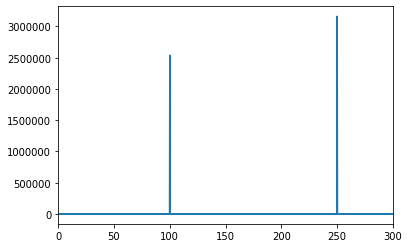

In [12]:
plt.plot(freq, np.abs(ft_div))
plt.xlim([0, 300])

Verificando esta o espectro apos a multiplicação vemos que o coeficiente de mais alta frequência possui maior amplitudo do que o de menor frequência. Observando a derivada teórica podemos verificar que o grafico concorda com o valor esperado.

$ y' = 2\pi100\cos(2\pi100t) + 2\pi 125\cos(2\pi250t)$

Ou seja, como a frequência passa a multiplicar a amplitudo da senoide na derivada a componente de maior frequência passa a possuir maior energia.


Agora, comparemos a derivada inversa com o valor teórico e a derivada calculada pelo metodo de diferenças finitas implementado pela função np.gradient.

In [13]:
y_diff = 2*np.pi*100*np.cos(2*np.pi*100*t)
y_diff += 2*np.pi*250*0.5*np.cos(2*np.pi*250*t) # Derivada teórica

In [14]:
y_ifft = np.real(np.fft.ifft(ft_div)) # Derivada FFT

In [15]:
y_finite_diff = np.gradient(y)*fs # Derivada diferenças finitas

(-1500, 1500)

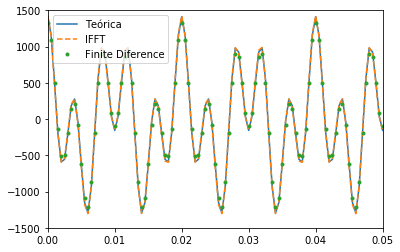

In [16]:
plt.plot(t, y_diff)
plt.plot(t, y_ifft, '--')
plt.plot(t, y_finite_diff, '.')
plt.legend(["Teórica", "IFFT", "Finite Diference"])
plt.xlim([0, 0.05])
plt.ylim([-1500, 1500])

Vemos que neste caso ambos os métodos concordam com o valor teórico. Porem podemos analisar o que acontece quando diminuimos o numero de pontos usados em cada um desses métodos.

###  Precição no calculo da derivada com FFT vs aproximação por diferenças finitas

In [17]:
fs = 2000 # Hz - Taxa de amostragem

tmax_tests = [0.5, 1, 1.5, 2, 2.5, 3] # s - Tempo do sinal amostrado

n_tests_samples = []
error_fft = []
error_finite_diff = []
for tmax in tmax_tests:
    t = np.arange(0, tmax, 1.0/fs)
    y = np.sin(2*np.pi*100*t)
    y += 0.5*np.sin(2*np.pi*250*t)
    
    freq = np.fft.fftfreq(t.shape[-1], 1/fs) # Frequencias discretas obtidas pela FFT
    
    # Calculating FFT
    ft = np.fft.fft(y)
    w = 2*np.pi*freq*1j
    ft_div = ft*w
    y_ifft = np.real(np.fft.ifft(ft_div))
    
    # Finite difference
    y_finite_diff = np.gradient(y)*fs
    
    # Theorical
    y_diff = 2*np.pi*100*np.cos(2*np.pi*100*t)
    y_diff += 2*np.pi*250*0.5*np.cos(2*np.pi*250*t)
    
    error_fft.append(np.mean(np.abs(y_diff-y_ifft)))
    error_finite_diff.append(np.mean(np.abs(y_diff-y_finite_diff)))
    n_tests_samples.append(len(t))

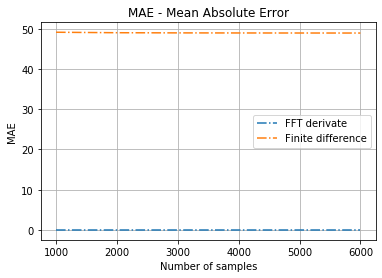

In [18]:
plt.title("MAE - Mean Absolute Error")
plt.plot(n_tests_samples, error_fft, '-.')
plt.plot(n_tests_samples, error_finite_diff, '-.')
plt.ylabel("MAE")
plt.xlabel("Number of samples")
plt.legend(["FFT derivate", "Finite difference"])
plt.grid()


Pode-se ver que usando a FFT obtemos um derivada muito mais próxima do valor teórico esperado.